# 7章 線形モデル上のバンディット問題のテスト

Author: hagino3000  
Date: 2016-11-30

「バンディット問題の理論とアルゴリズム」[1] の7章のアルゴリズムを実装して動かしてみる．

- LinUCB
- 線形モデル上のトンプソン抽出


[1] 「バンディット問題の理論とアルゴリズム」本多淳也／中村篤祥・著 http://www.kspub.co.jp/book/detail/1529175.html

### アルゴリズム 7.2
入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2 > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\tilde{\theta} を多変量正規分布 N(A^{-1}b, \sigma^2A^{-1}) から生成. \\
\hspace{10pt}i \leftarrow argmax_i\tilde{\theta}^{\mathrm{T}}_a{i,t} を選択して報酬 X(t) を観測. \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [4]:
# 真の報酬モデル
campaigns = {
    'campaign_a': 7,
    'campaign_b': 10,
    'campaign_c': 12
}
attribute = {
    'men_20': 1,
    'men_30': 50,
    'female_20': 8,
    'female_30': 20  
}
contextual_attr = {
    'design_a': 0,
    'design_b': 0,
    'font_a': 0,
    'font_b': 0
}
contextual_attrs = {
    'men_20': {
        'design': {
            'a': 20,
            'b': 10,            
        },
        'font': {
            'a': 2,
            'b': 1            
        }
    },
    'men_30': {
        'design': {
            'a': 5,
            'b': -1,            
        },
        'font': {
            'a': 10,
            'b': -10            
        }
    },
    'female_20': {
        'design': {
            'a': -30,
            'b': 50,            
        },
        'font': {
            'a': 10,
            'b': -10            
        }
    }, 
    'female_30': {
        'design': {
            'a': -20,
            'b': 30,            
        },
        'font': {
            'a': -10,
            'b': 7            
        }
    }
}

contextual_columns = []
contextual_values = []
for attr, attr_v in contextual_attrs.items():
    for el, el_v in attr_v.items():
        for type_name, value in el_v.items():
            contextual_columns.append(attr + '_' + el + '_' + type_name)
            contextual_values.append(value)

actions = []
for a in [campaigns.keys(), attribute.keys(), contextual_columns]:
    actions.extend(a)
theta = []
for a in [campaigns.values(), attribute.values(), contextual_values]:
    theta.extend(a)

In [5]:
# actionの要素
print(actions)

['campaign_a', 'campaign_c', 'campaign_b', 'female_20', 'men_30', 'female_30', 'men_20', 'female_20_design_b', 'female_20_design_a', 'female_20_font_b', 'female_20_font_a', 'men_30_design_b', 'men_30_design_a', 'men_30_font_b', 'men_30_font_a', 'female_30_design_b', 'female_30_design_a', 'female_30_font_b', 'female_30_font_a', 'men_20_design_b', 'men_20_design_a', 'men_20_font_b', 'men_20_font_a']


In [6]:
# 真の\theta
print(theta)

[7, 12, 10, 8, 50, 20, 1, 50, -30, -10, 10, -1, 5, -10, 10, 30, -20, 7, -10, 10, 20, 1, 2]


In [7]:
# 誤差項の既知の分散
var = [
    4, 4, 4,      # campaign (a,b,c)
    9, 9, 9, 9,   # ユーザー属性
    16, 16, 4, 4, # men_20
    16, 16, 4, 4, # men_30
    16, 16, 4, 4, # female_20
    16, 16, 4, 4  # female_30
]

In [8]:
empty_row = {}
for c in actions:
    empty_row[c] = 0

In [9]:
print(empty_row)

{'men_30_font_b': 0, 'female_20_design_b': 0, 'female_30_font_b': 0, 'men_20': 0, 'female_30': 0, 'female_20_font_b': 0, 'campaign_c': 0, 'men_30': 0, 'men_20_font_b': 0, 'men_30_font_a': 0, 'men_30_design_a': 0, 'men_20_design_b': 0, 'campaign_b': 0, 'female_30_design_b': 0, 'female_30_design_a': 0, 'men_30_design_b': 0, 'female_20': 0, 'men_20_design_a': 0, 'female_20_design_a': 0, 'campaign_a': 0, 'female_20_font_a': 0, 'men_20_font_a': 0, 'female_30_font_a': 0}


In [10]:
ret = []
for k, v in campaigns.items():
    cp = k
    cp_value = v
    for k, v in attribute.items():
        attr = k
        attr_value = v
        for k, v in contextual_attrs[attr]['design'].items():
            design = k
            design_value = v
            for k, v in contextual_attrs[attr]['font'].items():
                font = k
                font_value = v
                row = empty_row.copy()
                row[cp] = 1
                row[attr] = 1
                row[attr + '_design_' + design] = 1
                row[attr + '_font_' + font] = 1
                ret.append(row)

## 選択可能なactionの組み合わせ

In [11]:
df_actions = pd.DataFrame.from_dict(ret)
df_actions = df_actions[actions]
df_actions

,campaign_a,campaign_c,campaign_b,female_20,men_30,female_30,men_20,female_20_design_b,female_20_design_a,female_20_font_b,...,men_30_font_b,men_30_font_a,female_30_design_b,female_30_design_a,female_30_font_b,female_30_font_a,men_20_design_b,men_20_design_a,men_20_font_b,men_20_font_a
0,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
9,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [12]:
cov = np.identity(len(var))*var
def get_reward(action):
    return sum(np.random.multivariate_normal(action.T*theta, cov)*action)

In [16]:
def calc_new_a_inv(A_inv, a_i_t):
    return A_inv - (A_inv*(np.matrix(a_i_t).T)*(a_i_t)*A_inv)/(1 + a_i_t.dot(A_inv).dot(a_i_t))

In [17]:
contexts = [k for k in attribute.keys()]
def get_context(t):
    return contexts[t % len(contexts)]

In [18]:
def transpose(vec):
    return np.matrix(vec).T

In [19]:
def thompson_test(T=1000, input_sigma2=100, param_sigma02=100):
    # Input
    # input_sigma2 = 100 #sigma^2
    # Parameter
    # param_sigma02 = 100 #sigma_0^2
    # Start
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))

    # results
    rewards = []
    for t in range(T):
        theta_hat = np.random.multivariate_normal(A_inv.A.dot(b), input_sigma2*A_inv)
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = a_i.T.dot(theta_hat)
            selectable_actions.append(a_i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(estimated_rewards).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [23]:
def run_thompson_test(T, trial):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = thompson_test(T=T)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    plt.figure(figsize=(14, 2))
    plt.xlabel('time')
    plt.ylabel('Rewards')
    plt.plot(reward_gained_mean)
    print('Loss AVG:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

Loss AVG:53.31650754459978


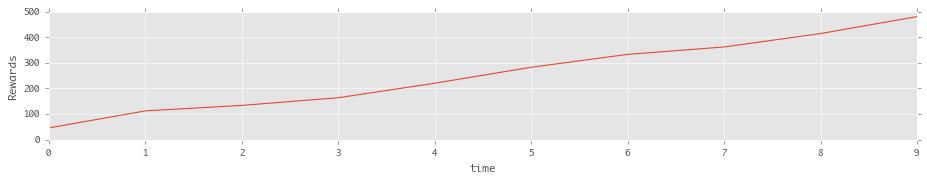

In [24]:
rewards_result = run_thompson_test(T=10, trial=10)

Loss AVG:-4.060374042166143


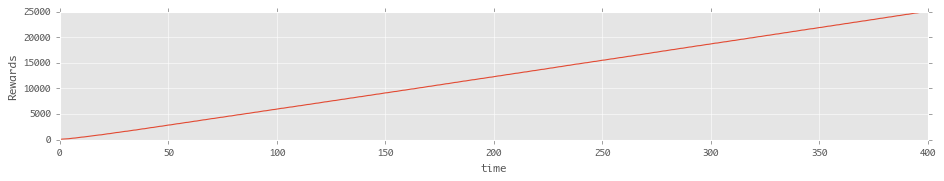

In [25]:
rewards_result = run_thompson_test(T=400, trial=10)